# **Lab 4: Function approximation**
**Fabián Levicán**

# **Abstract**

This is the fourth lab in the course DD2363 Methods in Scientific Computing. It is about using Jupyter to implement two methods: one for approximating a function from $\mathbb{R}$ to $\mathbb{R}$, and another for approximating a function from $\mathbb{R}^2$ to $\mathbb{R}$. These approximations are done using piecewise linear polynomials. Some objectives may be to become familiar with projections in Hilbert spaces, and with the usefulness of having a way to calculate integrals over domains of different shapes. The functions implemented are get1DPWLinearApproximation and get2DPWLinearApproximation. These functions are tested in a somewhat elaborate way, and the results are favorable.

#**About the code**

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Fabián Levicán (fils2@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files
from mpl_toolkits.mplot3d import Axes3D

import math
import time
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# **Introduction**

Many times in scientific computing we encounter functions that are integrable / piecewise continuous but which would be useful to approximate, for instance because of a need to evaluate it constantly and a high computational cost of doing so. The Stone Weierstrass theorem suggests that piecewise polynomials of finite degree may be good approximations.

We also know that, given a Hilbert space $V$ and a subspace $W$, the projection $v_W \in W$ of an element $v \in V$ minimizes the error $\|v - v_W\|_V$, and this error is orthogonal to all elements $w \in W$. In particular, if we have a basis $\phi = \{\phi_i\}_{i \in I}$ of $W$, this analysis eventually yields $\sum_{j \in I} \alpha_j \langle \phi_i, \phi_j \rangle = \langle v, \phi_i \rangle$ for all $i \in I$, where $\alpha = \{\alpha_j\}_{j \in I}$ is the vector of coordinates of $v_W$ in the basis $\phi$. This may be read as a linear system $A\alpha = b$ to solve for $\alpha$. If $A$ is sparse, this system is efficient to solve.

Here we implement the assembly and solution of these systems in the case of the space $V$ of piecewise continuous functions defined in a mesh, and the space $W$ of piecewise (dis)continuous linear polynomials associated to the mesh. We extensively use the facts that:
* The piecewise continuous linear polynomials in a 1D mesh have a basis which consists of the hat functions.
* The piecewise discontinuous linear polynomials in a 2D triangular mesh have a basis which consists of all the $\lambda_{i, 1}, \lambda_{i, 2}, \lambda_{i, 3}$, where $i$ is the index of a triangle, and $\lambda_{i, j}$ is a 2D shape function.

More details on the previous paragraph can be found in the lecture notes.

The variants of the methods the author chose to implement (and why) are described in their respective subsections.

# **Methods**

The method get1DLinearApproximation takes a SymPy function and a 1D mesh (a NumPy array with its nodes) as input and returns the NumPy array of the projection of the function evaluated at the nodes of the mesh. The author decided to assume that the function is continuous, in order to implement the algorithm for the continuous case, with which he was more familiar.

Let $n$ be the number of nodes of the mesh. The algorithm constructs a matrix $A \in \mathbb{R}^{n \times n}$ and a vector $b \in \mathbb{R}^{n}$ and then solves the system $A\alpha = b$ for $\alpha$. Finally, using the fact that $\pi(x_i) = \alpha_i$, where $\pi$ is the approximation and $x_i$ is the $i$-th node of the mesh, which follows from $\pi(x) = \sum_{0 \leq i < n} \alpha_i\lambda_i(x)$, the algorithm simply returns the vector $\alpha$.

To construct the matrix $A$ and the vector $b$, the algorithm iterates through its diagonal ($i$), and for every $i$ it constructs an upper triangular $LA \in \mathbb{R}^{2 \times 2}$ and a $Lb \in \mathbb{R}^2$. $LA$ is constructed by noting that $\left ( \begin{array}{cc} \int_{I_i} \lambda_{i, 0}\lambda_{i, 0} & \int_{I_i} \lambda_{i, 0}\lambda_{i, 1} \\ \int_{I_i} \lambda_{i, 1}\lambda_{i, 0} & \int_{I_i} \lambda_{i, 1}\lambda_{i, 1} \end{array}\right ) = \left ( \begin{array}{cc} h_i/3 & h_i/6 \\ h_i/6 & h_i/3 \end{array} \right )$ and ignoring the entry at $LA[1][0]$. These exact formulas were obtained from the lecture notes. $Lb[0] = \int_{I_i} f\lambda_{k, 0}$ and $Lb[1] = \int_{I_i} f\lambda_{k, 1}$. To map $LA$ to $A$, the algorithm adds $LA[0][0]$ to $A[i][i]$, $LA[0][1]$ to $A[i][i + 1]$ and to $A[i + 1][i]$, and $LA[1][1]$ to $A[i + 1][i + 1]$. This follows easily from the exact formulas for the entries $\langle \phi_i, \phi_j \rangle$ of $A$ obtained from the lecture notes. 

In [0]:
def get1DPWLinearApproximation(func, mesh):
  n = len(mesh) - 1
  LA = np.zeros((2, 2))
  Lb = np.empty(2)

  A = np.zeros((n + 1, n + 1))
  b = np.zeros(n + 1)

  for i in range(n):
    h = mesh[i + 1] - mesh[i]
    Lb[0] = sp.integrate(func*(mesh[i + 1] - x)/h, (x, mesh[i], mesh[i + 1]))
    Lb[1] = sp.integrate(func*(x - mesh[i])/h, (x, mesh[i], mesh[i + 1]))
    LA[0][0] = h/3
    LA[0][1] = h/6
    LA[1][1] = h/3
    b[i + 1] += Lb[1]
    b[i] += Lb[0]
    A[i][i] += LA[0][0]
    A[i][i + 1] += LA[0][1]
    A[i + 1][i] += LA[0][1]
    A[i + 1][i + 1] += LA[1][1]

  return np.linalg.solve(A, b)

x = sp.symbols('x')

# print(get1DPWLinearApproximation(x**2 + 1, np.array([-2.0, -1.0, 0.0, 1.0, 2.0])))

The method get2DPWLinearApproximation takes a Sympy function and a 2D triangular mesh data structure (a NumPy array $mesh$ where $mesh[i]$ is the $i$-th triangle in no particular order, $mesh[i][j]$ is its $j$-th vertex in no particular order ($0 \leq j < 3$), and $mesh[i][j][k]$ is its $k$-th coordinate ($0 \leq k < 2$)) and returns a list $projEval$ where $projEval[i]$ is a list where $projEval[i][0]$ is a NumPy array containing a point $x_i \in \mathbb{R}^2$, and $projEval[i][1]$ is a float number which is the evaluation of the approximation at point $x_i$. The points $x_i$ are all the unique points which are vertices of triangles in the mesh in no particular order. The author decided to use these data structures because he considered them intuitive. The author also decided to create a discontinuous piecewise linear approximation because he thought it was the easier to code than the continuous one.

The algorithm iterates through every triangle $i$, and constructs an upper triangular $LA \in \mathbb{R}^{3 \times 3}$. This local array is obtained from considering the entries of the global array that involve non-zero integrals in the triangle $i$, i. e.

$\left ( \begin{array}{ccc} \langle \phi_0, \phi_0 \rangle & \langle \phi_0, \phi_1 \rangle & \langle \phi_0, \phi_2 \\ \langle \phi_1, \phi_0 \rangle & \langle \phi_1, \phi_1 \rangle & \langle \phi_1, \phi_2 \rangle \\ \langle \phi_2, \phi_0 \rangle & \langle \phi_2, \phi_1 \rangle & \langle \phi_2, \phi_2 \rangle \end{array} \right )$

, where $\phi_0 = \lambda_{i, 1}$, $\phi_1 = \lambda_{i, 2}$ and $\phi_2 = \lambda_{i, 3}$. In a way analogous to the construction of the local matrix in the 1D case, this yields (along with the exact formulas obtained from the lecture notes):

$LA = \left ( \begin{array}{ccc} A_i/6 & A_i/12 & A_i/12 \\ 0 & A_i/6 & A_i/12 \\ 0 & 0 & A_i/6 \end{array} \right )$

The algorithm then fills in the global matrix $A$ in blocks of size $3 \times 3$, and the $3$ relevant entries in the global vector $b$ (i. e., $\int_{T_i} f\phi_j$, $0 \leq j < 3$) are calculated using the change to Barycentric coordinates described in [this](https://https://en.wikipedia.org/wiki/Barycentric_coordinate_system#Integration_over_a_triangle_or_tetrahedron) Wikipedia article, and using SymPy integration.

The resulting system $A\alpha = b$ is solved for $\alpha$. Then, a NumPy array $points$ of all the unique points which are vertices of triangles in the mesh is obtained. A mapping is also constructed to take each unique point to its list of relevant indices in the vector $\alpha$ (this is very simple because of the data strucutre choice). This latter part is used to evaluate the approximation at point $x_i$ by noticing that $\pi(x_i) = \sum_{j \in J} \alpha_j$, where $J$ is the set of relevant indices of $x_i$ in $\alpha$. This follows from an argument analogous to the one in the 1D case.




In [0]:
def get2DPWLinearApproximation(func, mesh):
  n = len(mesh)
  LA = np.zeros((3, 3))

  A = np.zeros((3*n, 3*n))
  b = np.empty(3*n)  

  for i in range(n):
    x1 = mesh[i][0]
    x2 = mesh[i][1]
    x3 = mesh[i][2]

    area = np.linalg.norm(np.cross(x2 - x1, x3 - x1))/2

    LA[0][0] = area/6
    LA[0][1] = area/12
    LA[0][2] = area/12
    LA[1][1] = area/6
    LA[1][2] = area/12
    LA[2][2] = area/6

    exp = x1*x + x2*y + x3*(1 - x - y)

    for j in range(3):
      if(j == 0):
        A[3*i + j][3*i + j] = LA[0][0]
        A[3*i + j][3*i + j + 1] = LA[0][1]
        A[3*i + j][3*i + j + 2] = LA[0][2]
        b[3*i + j] = 2*area*sp.integrate(func.subs([(u, exp[0]), (v, exp[1])])*x, (x, 0, 1 - y), (y, 0, 1))
      elif(j == 1):
        A[3*i + j][3*i + j - 1] = LA[0][1]
        A[3*i + j][3*i + j] = LA[1][1]
        A[3*i + j][3*i + j + 1] = LA[1][2]
        b[3*i + j] = 2*area*sp.integrate(func.subs([(u, exp[0]), (v, exp[1])])*y, (x, 0, 1 - y), (y, 0, 1))
      else:
        A[3*i + j][3*i + j - 2] = LA[0][2]
        A[3*i + j][3*i + j - 1] = LA[1][2]
        A[3*i + j][3*i + j] = LA[2][2]
        b[3*i + j] = 2*area*sp.integrate(func.subs([(u, exp[0]), (v, exp[1])])*(1 - x - y), (x, 0, 1 - y), (y, 0, 1))

  alpha = np.linalg.solve(A, b)

  points = np.unique(mesh.reshape(len(mesh)*3, 2), axis=0)

  nPoints = len(points)

  pointsToIndices = list()
  for k in range(nPoints):
    pointsToIndices.append(list())
  for i in range(n):
    for j in range(3):
      for k in range(nPoints):
        if(np.isclose(mesh[i][j], points[k]).all()):
          pointsToIndices[k].append(3*i + j)

  projEval = list()
  for k in range(nPoints):
    projEval.append(list())
  for k in range(nPoints):
    sum = 0
    for index in pointsToIndices[k]:
      sum += alpha[index]
    projEval[k].append(points[k])
    projEval[k].append(sum)

  return projEval

x = sp.symbols('x')
y = sp.symbols('y')
u = sp.symbols('u')
v = sp.symbols('v')

# mesh = np.array([[[-10, 10], [0, 0], [10, 10]], [[-10, -10], [-10, 10], [0, 0]], [[-10, -10], [0, 0], [10, -10]], [[0, 0], [10, -10], [10, 10]]])

# print(get2DPWLinearApproximation(u**2+v**2+1, mesh))

# **Results**

To verify the accuracy of the approximation obtained by the function get1DPWLinearApproximation and to obtain its rate of convergence an auxiliary function construct1DMesh was written which takes a positive integer $nCuts$ and returns the 1D mesh which divides the interval $[-10, 10]$ into $nCuts$ subintervals. The method get1DPWLinearApproximation was tested with $10$ such divisions ($i$), starting with $nCuts = 3$, and with the function $f(x) = x^2 + 1$. A NumPy array $accuracy$ was constructed such that $accuracy[i] = \|f(mesh) - \pi(mesh)\|$, where evaluation of a function at $mesh$ is done entry-wise. A NumPy array $rateOfConvergence$ was constructed such that $rateOfConvergence[i] = accuracy[i + 1] - accuracy[i]$. This rate of convergence can be thought of vaguely as $\frac{\Delta accuracy}{\Delta i}$, so it shows a bona fide notion of convergence.

As shown in the graph plotted after running the following code, the accuracy (blue) approaches $0$, and the rate of convergence (red) also does. This implies that the approximation becomes better at each iteration, so the results are favourable.

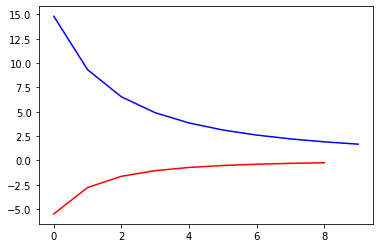

In [5]:
def construct1DMesh(nCuts):
  h = 20.0/nCuts
  mesh = np.empty(nCuts + 1)
  for i in range(nCuts):
    mesh[i] = -10 + i*h
  mesh[nCuts] = 10
  return mesh

x = sp.symbols('x')
y = sp.symbols('y')
u = sp.symbols('u')
v = sp.symbols('v')

accuracy = np.empty(10)
rateOfConvergence = np.empty(9)
for i in range(10):
  mesh = construct1DMesh(3 + i)
  vectorizedFunc = np.vectorize(lambda t: t**2 + 1)
  exactEval = vectorizedFunc(mesh)
  projEval = get1DPWLinearApproximation(x**2 + 1, mesh)
  accuracy[i] = np.linalg.norm(exactEval - projEval)
for i in range(9):
  rateOfConvergence[i] = accuracy[i + 1] - accuracy[i]

plt.plot(accuracy, color="blue")
plt.plot(rateOfConvergence, color="red")


To test the get2DPWLinearApproximation function an analogous test is performed, although the 1D mesh is now a 2D mesh obtained by dividing the region $[-10, 10]^2$ into $2*nCuts^2$ isosceles triangles. The $x$ and $y$ components are divided in a way similar to the $1D$ case, and the resulting squares are each divided into $2$ triangles at the diagonal that goes from bottom left to top right. The only other significant difference to the 1D case is that $accuracy$ is defined such that $accuracy[i] = avg(f(points) - \pi(points))$, where $points$ is the NumPy array of unique points in the mesh in an arbitrary but consistent order, and evaluation of a function at $points$ is done entry-wise. This change in the definition of $accuracy$ was made because the author feared that the definition with the norm would grow too much as adding points to the mesh also adds more dimensions to the evaluation arrays.

The function that was tested is $f(x, y) = x^2 + y^2 + 1$.

As shown in the graph, the accuracy (blue) seems to approach a quantity close to $-270$, as the rate of convergence (red) approaches $0$. While this is not favorable in itself, the author suspects it is a problem of:
* Either the definition of accuracy. The author couldn't come up with a better one in a limited time.
* Or a sequence of isolated points that, for a reason unknown to the author, move the average by an amount that becomes stable as the mesh becomes more divided.

Finally, the author plotted a 3D scatter of the approximation evaluated at the points in the most divided mesh, and it can be easily seen that it is very similar to the exact function evaluated at the same points (the author didn't plot the exact function, as it is a very simple one). Also, as the approximation obtained using the most divided is certainly better than the one obtained using the least divided mesh, the function displays convergence to the exact function.

The results are, thus, favourable.

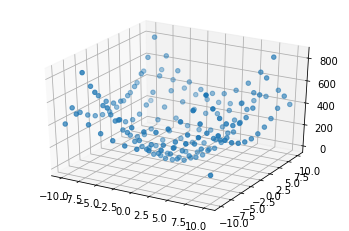

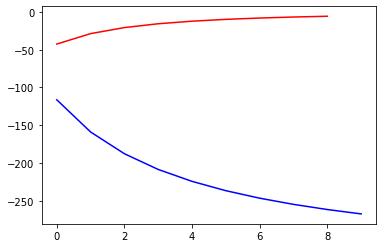

In [6]:
def construct2DMesh(nCuts):
  h = 20.0/nCuts
  mesh = np.empty((2*nCuts**2, 3, 2))
  for i in range(nCuts):
    for j in range(nCuts):
      mesh[2*(i*nCuts + j)] = np.array([[-10 + i*h, -10 + j*h], [-10 + i*h, -10 + (j + 1)*h], [-10 + (i + 1)*h, -10 + (j + 1)*h]])
      mesh[2*(i*nCuts + j) + 1] = np.array([[-10 + i*h, -10 + j*h], [-10 + (i + 1)*h, -10 + j*h], [-10 + (i + 1)*h, -10 + (j + 1)*h]])
  return mesh

def func(point):
  return point[0]**2 + point[1]**2 + 1

x = sp.symbols('x')
y = sp.symbols('y')
u = sp.symbols('u')
v = sp.symbols('v')

accuracy = np.empty(10)
rateOfConvergence = np.empty(9)
for i in range(10):
  mesh = construct2DMesh(3 + i)
  result = get2DPWLinearApproximation(u**2 + v**2 + 1, mesh)
  points = np.array([r[0] for r in result])
  exactEval = np.array([point[0]**2 + point[1]**2 + 1 for point in points])
  projEval = np.array([r[1] for r in result])
  accuracy[i] = np.average(exactEval - projEval)
  if(i == 9):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([point[0] for point in points], [point[1] for point in points], projEval)
    plt.show()
for i in range(9):
  rateOfConvergence[i] = accuracy[i + 1] - accuracy[i]

plt.plot(accuracy, color="blue")
plt.plot(rateOfConvergence, color="red")

# **Discussion**

The author found most surprising that the fact that the norm in $\mathbb{R}^n$ becomes larger in general (in a certain sense) as $n$ becomes larger has very practical implications (see the second function's test description).

The author also thinks that the second reason stated in the second function's test description is the most likely cause for the partial failure of that test, and that it may show a (small) mistake in either the second function's implementation or the test itself. For better testing, a better assessment of the accuracy of the approximations and their rate of convergence could be implemented.

Sources of error may be introduced if the mesh is too divided, as the author used only the default tolerance of NumPy methods for floating point number comparison.

The author collaborated with Felipe Vicencio.